# SMS spam filter using a naive Bayes algorithm

The aim of this project is to build a simple Short Message Service (SMS) spam filter, *i.e.*, a function taking a string as input and returning `True` if the message is a spam, and `False` if it is not.
We will use a multinomial Bayes algorithm, which is first trained on a corpu of spam and non-spam messages. 

## A few words on the algorithm

Schematically, the algorithm works in the following way. 
We start from a corpus of many text messages labeled as spam or non-spam. 
Let $N_s$ be the total number of words in spam messages and $N_{ns}$ the tota number of words in non-spam messages. 
Let $V$ be the size of the vocabulary, *i.e.*, the total number of different words in the corpus. 
Let us choose a positive number $\alpha$, hereafter called the smoothing parameter.
For each word $w$, we denote by $N_{w|s}$ the number of times $w$ appears in spam messages and by $N_{w|ns}$ the number of times it appears in non-spam messages. 
We then define the two weights $p_{w|s}$ and $p_{w|ns}$ by: 
$$p_{w|s} = \frac{N_{w|s} + \alpha}{N_s + \alpha V}$$
and
$$p_{w|ns} = \frac{N_{w|ns} + \alpha}{N_{ns} + \alpha V}.$$

To build some intuition as to what these weights mean, let us consider two particular cases: 
* If $\alpha = 0$, we have $p_{w|s} = \frac{N_{w|s}}{N_s}$: this is he number of times the word $w$ apears in spam messages divided by the total number of words in spams.
Assuming the corpus we are working with is representative, $p_{w|s}$ should thus be close to the probability for a word randomly chosen in a set of spam messages to be equal to $w$. 
Similarly, $p_{w|ns}$ should be close to the probability for a word randomly chosen in a set of non-spam messages to be equal to $w$. 
These are the weights one would use in a standard Bayesian analysys.
* The problem with these weight is that they vanish if $N_{w|s} = 0$ or $N_{w|ns} = 0$, respectively, *i.e.*, if the word $w$ never appears in spam or in non-spam messages present in the corpus. 
This is a problem because new messages may contain this word. 
For instance, if our spam filter were trained with the standard Bayesian weights, any message which contains a word which, in the corpus used for training, is present only in non-spam messages, would be classified as non-spam even if the rest of its content clearly indicates it is a spam.
The parameter $\alpha$ is introduced to circumvent this limitation. 
Indeed, if $N_{w|s} = 0$, for instance, we get $p_{w|s} = \frac{\alpha}{N_s + \alpha V}$: a typically small, but non-vanishing number. 
* This parameter also prevents the denominator from being small if the corpus contains too few spam or non-spam messages. 
For instance, if $N_s \ll V$, we get $p_{w|s} = \frac{N_{w|s} + \alpha}{\alpha V}$. 
The larger denominator can prevent the model from being too sensitive to small variations in $N_{w|s}$.

Let $m$ be a message (not necessarily in the corpus) made of a succession of $n$ words $w_1$, $w_2$, ..., $w_n$. 
We define the two weights $p_{m|s}$ and $p_{m|ns}$ by: 
$$p_{m|s} = \prod_{i=1}^n p_{w_i|s}$$
and 
$$p_{m|ns} = \prod_{i=1}^n p_{w_i|ns}.$$
(Notice that these definitions are compatible with the above ones if $m$ has exactly one word.)
We then estimate the probability $P_{s|m}$ that $m$ is a spam as 
$$P_{s|m} \equiv \frac{p_{m|s} P_s}{p_{m|s} P_s + p_{m|ns} (1-P_s)},$$
where $P_s$ is the probability that any message is a spam, and label it as spam if $P_{s|m} > 0.5$.

For $\alpha = 0$ and assuming that each word composing $m$ is in the corpus, $P_{s|m}$ would be the probability that $m$ is a spam given by Bayes' theorem starting from a prior $P_s$ and assuming the words are independent of each others. 
As mentioned above, the parameter $\alpha$ is introduced to account for words missing in spams or non-spams in the corpus. 
In the following, we will first choose the prior $P_s = 0.5$, minimizing the Shannon entropy. 
It could be tempting to improve the estimate by choosing a different prior, *i.e.*, taking the ratio of spam messages in the corpus. 
However, this would increase the dependence of the outcome in the representativity of the corpus. 
For this reason, in this project we will first stick to a prior of $0.5$. 
We will then see whether changing the prior can improve the results. 

The corpus we will use is in the text file `SMSSpamCollection`, downloaded from [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) on 23 February 2020. 
It was very slightly modified (I added a quotation mark at the end of line 5082) to ease the import as a Pandas dataframe.
It consists of 425 SMS spam messages collected from the Grumbletext website (which seems to be offline at the time of writing (23/02/2020)), 3,375 SMS messages randomly selected from the 10,000 of the NUS SMS Corpus (also offline at the time of writing), 450 SMS ham messages collected from [Caroline Tag's PhD Thesis](https://etheses.bham.ac.uk/id/eprint/253/1/Tagg09PhD.pdf), and 1324 messages from the [SMS Spam Corpus v.0.1 Big](https://www.esp.uem.es/jmgomez/smsspamcorpus/).

## Data Exploration

Let us first import the Pandas module, which we will use to read and explore the corpus, and the Re module to work with regular expressions.
We alsoimport the Pyplot library, which will be used to produce a plot.

In [1]:
import pandas as pd
import re
from matplotlib import pyplot as plt

We then load the corpus in the `corpus` dataframe:

In [2]:
# two columns separated by a tab, no header
# the first column is the label and the second one the message
corpus = pd.read_csv('../Data/smsspamcollection/SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

To ease the analysis, we convert the column `Label` to boolean values, replacing `ham` (denoting a non-spam message) by `False` and `spam` by `True`:

In [3]:
corpus['Label'] = corpus['Label'].replace({'ham':False, 'spam':True})

Let us print a few informations about the dataframe:

In [4]:
summary = corpus.describe()
display(summary)
nrows = summary.loc['count','Label']
print(summary.loc['freq','Label']/nrows)

,Label,SMS
count,5574,5574
unique,2,5171
top,False,"Sorry, I'll call later"
freq,4827,30


0.8659849300322928


It has 5574 rows, as expected. 
Most of them (4825, *i.e.*, approximately 87%) correpond to non-spam messages.

## Training and test sets

We now separate the corpus into a training and a test sets. 
The later will contain approximately 20% of all messages. 

In [5]:
# fraction of messages used for the test
frac_test = 0.2

# randomizing the sample, using a  particular random state to make the results 
# reproducible (this should not be done in real-world applications!)
corpus_rand = corpus.sample(frac=1, random_state=1)

# separate it into the training and test dataframes
n_messages_training = int((1.-frac_test)*nrows)
corpus_training = corpus_rand.iloc[:n_messages_training]
corpus_test = corpus_rand.iloc[n_messages_training:]

To see whether they are representative, let us compute the percentage of spam messages in each of these dataframes:

In [6]:
def percentage_spam(df):
    return 100 * df['Label'].sum() / df.shape[0]

phrase = 'Percentage of spam messages in the {} dataframe: {}%'
print(phrase.format('training', percentage_spam(corpus_training)))
print(phrase.format('test', percentage_spam(corpus_test)))

Percentage of spam messages in the training dataframe: 13.47835837631756%
Percentage of spam messages in the test dataframe: 13.094170403587444%


Both dataframes have between 13.0% and 13.5% of spam messages, which is close to the percentage of spams in the full corpus. 
They thus seem to be representative. 

## Building the corpus of words

We now want to extract the words from messages in the traning set. 
To this end, we first replace all non-alphanumerical characters by spaces and convert all letters to lowercase: 

In [7]:
corpus_training = corpus_training.copy() # to prevent an irrelevant warning
corpus_training['SMS'] = corpus_training['SMS'].str.replace('\W', ' ')
corpus_training = corpus_training.copy() # to prevent a false warning
corpus_training.loc[:,'SMS'] = corpus_training['SMS'].str.lower()
corpus_training

,Label,SMS
1447,False,looks like u wil b getting a headstart im leav...
2032,False,i noe la u wana pei bf oso rite k lor o...
4432,False,2mro i am not coming to gym machan goodnight
4888,True,todays vodafone numbers ending with 4882 are s...
5276,False,hi hope ur day good back from walk table ...
...,...,...
4255,False,how about clothes jewelry and trips
1982,False,sorry i ll call later in meeting any thing re...
4755,False,ok lor or u wan me go look 4 u
4020,True,u ve been selected to stay in 1 of 250 top bri...


We now define the set `vocabulary` containing all the words present in training messages:

In [8]:
vocabulary = {w for i in range(corpus_training.shape[0]) for w in corpus_training.iloc[i, 1].split()}

The two dictionaries `count_words_spam` and `count_words_non_spam` count the number of occurrences of each word in the spam and non-spam messages, respectively:

In [9]:
count_words_spam = dict()
count_words_non_spam = dict()
for i in range(corpus_training.shape[0]):
    if corpus_training.iloc[i,0]: # if the message is a spam
        for w in corpus_training.iloc[i, 1].split():
            if w in count_words_spam:
                count_words_spam[w] += 1
            else:
                count_words_spam[w] = 1
    else:
        for w in corpus_training.iloc[i, 1].split():
            if w in count_words_non_spam:
                count_words_non_spam[w] += 1
            else:
                count_words_non_spam[w] = 1

We now compute the total number `Ns` of words in spams, `Nns` of words in non-spam messages, and the size `V` of the vocabulary:

In [10]:
Ns = sum(count_words_spam.values())
Nns = sum(count_words_non_spam.values())
V = len(vocabulary)

The prior probability of a message being a spam, `Ps`, is set to 0.5, and the smoothing parameter `alpha` to 1.

In [11]:
Ps = 0.5
alpha = 1.

## Computing $p_{w|s}$ and $p_{w|ns}$

To make the spam filter more efficient, we pre-compute the conditional probabilities for each word in the vocabulary to appear given that a message is or is not a spam. 
The results are stored in the dictionaries `p_w_s` and `p_w_ns`. 
We also define the weight `p_not_in_V_s` and `p_not_in_V_ns` for a word not in the vocabulary.

In [12]:
p_w_s = {w: (count_words_spam[w] + alpha) / (Ns + alpha*V) for w in count_words_spam}
p_w_ns = {w: (count_words_non_spam[w] + alpha) / (Nns + alpha*V) for w in count_words_non_spam}

p_not_in_V_s = alpha / (Ns + alpha*V)
p_not_in_V_ns = alpha / (Nns + alpha*V)

## The `classify` function

We define the `classify` function taking a message as a string and returning `True ` if it seems to be a spam and `False` otherwise. 
If the argument `probability` is set to `True`, it returns the probability that the message is a spam instead.

In [13]:
def classify(message, probability=False, 
             threshold = 0.5, minval = 10.**(-50)):
    '''
    Function to estimate if the message seems to be a spam.
    If probability is False, it returns True if the message seems to be a spam 
    and False otherwise. 
    If probability is True, it returns the estimated probability for the 
    message to be a spam.
    If weights fall below minval, we increase them to avoid reaching 0.
    The parameters thresholdis the probability above which we consider the 
    message is a spam.
    '''
    
    # convert the message to lowercase and replace non-alphanumerical characters by spaces
    message = re.sub('\W', ' ', message).lower()
    
    # split the message into words
    words = message.split()
    
    # if there is no word, stop the analysis
    if not words:
        print('I can\'t find any word in this message')
        return None
    
    # compute p_{m|s} and p_{m|ns}
    p_m_s = 1.
    p_m_ns = 1.
    for w in words:
        if w in p_w_s: 
            p_m_s *= p_w_s[w]
        else: 
            p_m_s *= p_not_in_V_s
        if w in p_w_ns: 
            p_m_ns *= p_w_ns[w]
        else: 
            p_m_ns *= p_not_in_V_ns
        while (p_m_s < minval) or (p_m_ns < minval): 
            p_m_s *= 2
            p_m_ns *= 2
            
    # compute P_{s|m}
    P_s_m = p_m_s * Ps / (p_m_s * Ps + p_m_ns * (1.-Ps))
    
    if probability:
        return P_s_m
    else:
        return P_s_m > threshold

Let us test it on two messages: one which is probably a spam and one which is probably not.

In [14]:
probably_spam = 'WINNER!! This is the secret code to unlock the money: C3421.'
probably_non_spam = "Sounds good, Tom, then see u there"

print(classify(probably_spam))
print(classify(probably_non_spam))

True
False


## Testing the `classify` function

Let us now test this function on the test set. 
We define the accuracy as the fraction of messages correctly labeled. 
We store the indices of the mislabeled messages in the list `mislabeled`.

In [15]:
correct = 0
total = 0
mislabeled = []

for i in range(corpus_test.shape[0]):
    total += 1
    if classify(corpus_test.iloc[i,1]) == corpus_test.iloc[i,0]:
        correct += 1
    else: 
        mislabeled.append(i)

accuracy = correct / total
print('The accuracy is: {:.3f}'.format(accuracy))

The accuracy is: 0.963


Our spam filter reaches an accuracy of 0.96, which is fairly good.

## Changing the prior

Let us now see what happens if taking as prior the fraction of spams in the training set.

In [16]:
N_s_training = corpus_training['Label'].sum()
N_ns_training = corpus_training.shape[0] - N_s_training
Ps = N_s_training / (N_s_training + N_ns_training)

correct = 0
total = 0
mislabeled = []

for i in range(corpus_test.shape[0]):
    total += 1
    if classify(corpus_test.iloc[i,1]) == corpus_test.iloc[i,0]:
        correct += 1
    else: 
        mislabeled.append(i)

accuracy = correct / total
print('The accuracy is: {:.3f}'.format(accuracy))

The accuracy is: 0.984


The accuracy becomes larger than 0.98, which seems to indicate that it is a more suitable choice of prior. 
Let us see which messages are still mislabeled: 

In [17]:
corpus_test.iloc[mislabeled]

,Label,SMS
3460,True,Not heard from U4 a while. Call me now am here...
3890,False,Unlimited texts. Limited minutes.
991,False,26th OF JULY
989,False,Yun ah.the ubi one say if ü wan call by tomorr...
4488,False,Miss call miss call khelate kintu opponenter m...
326,False,No calls..messages..missed calls
3149,False,CHEERS U TEX MECAUSE U WEREBORED! YEAH OKDEN H...
2419,False,"Madam,regret disturbance.might receive a refer..."
3864,True,Oh my god! I've found your number again! I'm s...
4676,True,"Hi babe its Chloe, how r u? I was smashed on s..."


Most of them are genuine messages mislabeled as spams.

## Taking new messages into account

One of the features of machine learning compared with classical statistical anaysis is the possibility to continually learn by including new information. 
To take advantage of this, we define the function `update` taking a message as a string, a label `True` or `False`, and updating the parameters. 

In [18]:
def update(message, is_spam, change_prior=False):
    '''
    This function updates the spam filter given a new message and a label 
    is_spam equal to true if it is a spam and False otherwise. 
    If change_prior is true, the prior Ps is updated
    
    message: string
    is_spam: bool
    change_prior: bool (optional)
    '''
    
    # define variables as global to be able to modify them 
    global N_s_training, N_ns_training, Ps, p_w_s, p_w_ns, p_not_in_V_s, \
           p_not_in_V_ns, count_words_spam, count_words_non_spam, Ns, Nns, \
           vocabulary, V
    
    # add new words to the vocabulary
    
    if is_spam:
        N_s_training += 1
        for word in re.sub('\W', ' ', message).lower().split():
            vocabulary.add(word)
            if w in count_words_spam:
                count_words_spam[w] += 1
            else:
                count_words_spam[w] = 1
        V = len(vocabulary)
        Ns = sum(count_words_spam[w] for w in count_words_spam)
    else:    
        N_ns_training += 1
        for word in re.sub('\W', ' ', message).lower().split():
            vocabulary.add(word)
            if w in count_words_non_spam:
                count_words_non_spam[w] += 1
            else:
                count_words_non_spam[w] = 1
        V = len(vocabulary)
        Nns = sum(count_words_non_spam[w] for w in count_words_non_spam)
        
    if change_prior:
        Ps = N_s_training / (N_s_training + N_ns_training)
    
    p_w_s = {w: (count_words_spam[w] + alpha) / (Ns + alpha*V) for w in count_words_spam}
    p_w_ns = {w: (count_words_non_spam[w] + alpha) / (Nns + alpha*V) for w in count_words_non_spam}

    p_not_in_V_s = alpha / (Ns + alpha*V)
    p_not_in_V_ns = alpha / (Nns + alpha*V)

## Changing the value of $\alpha$

Let us now see how changing $\alpha$ affects the results. 
To this end, we define the function `update_alpha_and_train` wich changes the value of $\alpha$, re-trains the model, and prints its acuracy.

In [19]:
def update_alpha_and_train(new_alpha):
    '''
    update the value fof alpha, re-train the model, and return its accuracy
    '''
    global alpha, p_w_s, p_w_ns, p_not_in_V_s, p_not_in_V_ns
    
    # update alpha
    alpha = new_alpha

    # re-compute the weights
    p_w_s = {w: (count_words_spam[w] + alpha) / (Ns + alpha*V) for w in count_words_spam}
    p_w_ns = {w: (count_words_non_spam[w] + alpha) / (Nns + alpha*V) for w in count_words_non_spam}

    p_not_in_V_s = alpha / (Ns + alpha*V)
    p_not_in_V_ns = alpha / (Nns + alpha*V)

    correct = 0
    total = 0
    mislabeled = []

    for i in range(corpus_test.shape[0]):
        total += 1
        if classify(corpus_test.iloc[i,1]) == corpus_test.iloc[i,0]:
            correct += 1
        else: 
            mislabeled.append(i)

    accuracy = correct / total
    return accuracy

We try with $\alpha$ ranging from 0.0001 to 10:

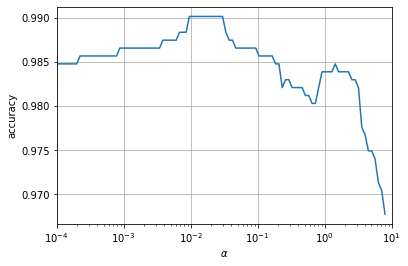

In [20]:
alpha_min = 0.0001
alpha_max = 10.
n_values = 100

alpha_values = [alpha_min*(alpha_max/alpha_min)**(i/(n_values+1)) for i in range(n_values)]
acc_values = list(map(update_alpha_and_train, alpha_values))

plt.semilogx(alpha_values, acc_values)
plt.xlim(alpha_min, alpha_max)
plt.xlabel(r'$\alpha$')
plt.ylabel('accuracy')
plt.grid()

The resulting accuracy seems to be virtually independent of $\alpha$, although choosing $\alpha = 0.01$ seems to give the best results, with an accuracy of $0.99$.

## Conclusion

In this project, we built a classifier to determine whether an SMS is a spam or not, using a naive Bayes algorithm. 
We found that best results are achived when whoosing as prior the fraction of spam messages in the corpus and a value of the smoothing parameter close to 0.01. 
The resulting accuracy was 99%. 

This indcates that, if this model were to be used in real-world applications, a good prior to start with would be the fraction of SMS received by a user that are spam. 
The optimum value of $\alpha$ will likely depend on the size ot the corpus (we expect it to decrease as the size of the corpus increses). 
From our results, taking $\alpha = 0.01$ should be a good starting value if the available corpus has a few thousand messages. 